<a href="https://colab.research.google.com/github/Jollyhrothgar/wordle/blob/main/Wordle_Solver_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Wordle is a word guessing game where the player needs to guess a five letter word. There are six chances to get the word right, and with each guess, you get information:

* Letters that are not in the word
* Letters that are in the word, but are not in the right position
* Letters thar are in the word and in the right position

## Games

* [Wordle](https://www.powerlanguage.co.uk/wordle/)
* [Lewdle](https://www.lewdlegame.com/)

# Strategy

Since the first word is a complete guess, the optimal guess is the one that obtains the most information. Some strageies:

## Letter frequencies

Goal: try to eliminate as many letters as possible.

1. Pick a word with distinct letters
2. Choose a word that contains the most common letters
3. First guess eliminates the most uncertainty

## Letter position frequencies

Goal: try to eliminate as many positions as possible

1. Pick a word that has distinct letters, as well as most common letter positions
2. Choose word that eliminates the most position-letter pairs
3. First guess (hopefully) eliminates both a letter AND a position.

In [ ]:
#@title Imports
import urllib.request as request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import re

In [ ]:
#@title Utils

def load_wordlist_from_url(url):
  """Assume URL hosts a plan newline deliminated wordlist, and load to array"""
  return [line.decode("utf-8").strip().lower() for line in request.urlopen(url)]

def make_word_df(word_list):
  """Create the word dataframe data structure"""
  words = pd.DataFrame(word_list, columns=['word'])
  words[1] = words['word'].apply(lambda x: x[0])
  words[2] = words['word'].apply(lambda x: x[1])
  words[3] = words['word'].apply(lambda x: x[2])
  words[4] = words['word'].apply(lambda x: x[3])
  words[5] = words['word'].apply(lambda x: x[4])

  return words

class Guesser(object):
  def __init__(self, word_df):
    self.word_df = word_df
    self.orignal_word_df = word_df.copy(deep=True)
    self.compute_probability_and_frequency()
    self.solved = {
        1: "?",
        2: "?",
        3: "?",
        4: "?",
        5: "?",
    }
  
  def is_solved(self):
    return len(self.word_df) == 1
  
  def snapshot_word_list(self):
    self.snapshot = self.word_df.copy(deep=True)

  def restore_word_list_snapshot(self):
    self.word_df = self.snapshot.copy(deep=True)

  def compute_probability_and_frequency(self):
    """Given a word_list of words, compute the joint probability of all letter
    positions."""
    letter_frequency = pd.Series(
        [letter for word in self.word_df['word'].values for letter in word]
    ).value_counts(normalize=True).sort_index()
  
    position_frequency = pd.concat(
      [
        self.word_df[1].value_counts(),
        self.word_df[2].value_counts(),
        self.word_df[3].value_counts(),
        self.word_df[4].value_counts(),
        self.word_df[5].value_counts()
      ],
      axis=1
    ).fillna(0)
    position_joint = position_frequency.div(position_frequency.sum()).sort_index()
  
    self.position_joint = position_joint  
    self.letter_frequency = letter_frequency

  def pick_word(self, strategy='letter_frequency'):
    """Pick word based on strategy"""
    self.snapshot_word_list()

    if strategy=='letter_frequency':
      if self.word_df.shape[0] == 1:
        return self.word_list['word'].values[0]
  
      letters = self.letter_frequency.sort_values(ascending=False).index.values
      solved_letters = set(self.solved.values())
  
      try:
        solved_letters.remove('?')
      except:
        pass
  
      letters = list(set(letters).difference(solved_letters))
      
      counter = 0
      letter = letters.pop(0)
      list_length = sum(self.word_df['word'].str.contains(letter) > 0)
  
      while list_length > 0:
        self.word_df = self.word_df[self.word_df['word'].str.contains(letter) > 0]
        list_length = sum(self.word_df['word'].str.contains(letter) > 0)
        try:
          letter = letters.pop(0)
        except IndexError: # no more letters to pop, we're in anagram land.
          break
        counter += 1
        if counter == 5:
          break
      self.restore_word_list_snapshot()
      return self.word_df.sample(1)['word'].values[0]
    else:
      # Default is random
      return self.word_df.sample(1)['word'].values[0]
  
  def guess(self, guess, secret_word, silent=False):
    """Call self.add_hint using a guessed word and a secret word.
    """
    word_count = self.word_df.shape[0]

    # Check for location matches
    for (i, letter) in enumerate(guess):
      if guess[i] == secret_word[i]:
        self.add_hint(letter=letter, location=i+1)
        if not silent:
          print(f'\t{letter} is solved at {i+1}')
      elif letter in secret_word:
        if not silent:
          print(f'\t{letter} is in secret word')
        self.add_hint(letter=letter, location=-1*(i+1))
      else:
        if not silent:
          print(f'\t{letter} is not in the word.')
        self.add_hint(letter=letter)

    return word_count - self.word_df.shape[0]
      
  def add_hint(self, letter, location=None, silent=True):
    """Add a hint about information in the word

    letter: a lowercase letter in the alphabet
    location: takes on following values / meaning:
      None: the letter is not in the word
      (-1, -2, -3, -4, -5): the letter is in the word, but NOT in the position
      (1, 2, 3, 4, 5): the letter is in the position.
    state: True or False - true if the position has the letter, false if it
      doesn't.
    """

    # Apply logic in a way that doens't require knowledge of previous moves
    # and does not reduce the word-list to zero words.
    if location is None:
      temp_df = self.word_df[~self.word_df['word'].str.contains(letter)]
      if len(temp_df) != 0:
        self.word_df = temp_df
    else:
      if location > 0:
        temp_df = self.word_df[self.word_df[location] == letter]
        if len(temp_df) != 0:
          self.word_df = temp_df
      else:
        location = abs(location)
        temp_df = self.word_df[self.word_df[location] != letter]
        if len(temp_df) != 0:
          self.word_df = temp_df
        
        temp_df = self.word_df[self.word_df['word'].str.contains(letter)]
        if len(temp_df) != 0:
          self.word_df = temp_df

    self.compute_probability_and_frequency()
    for pos in [1, 2, 3, 4, 5]:
      # Floating point, be careful.
      if max(self.position_joint[pos]) > 0.99999:
        self.solved[pos] = self.position_joint[pos].idxmax()
    
    if self.is_solved():
      if not silent:
        print(f"\tSecret word is solved: {self.word_df['word'].values[0]}")

  def plot_words(self):
    words_df = self.compute_probability_and_frequency()

    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

    # Letter Joint
    sns.heatmap(self.position_joint, cmap='Blues', annot=True, fmt='.3f', ax=ax_l)
    ax_l.set_title('Wordle Joint Distribution \n $P(letter, position)$')
  
    # Letter frequency
    self.letter_frequency.plot.bar(
        title='letter frequency',
        xlabel='letter',
        ylabel='frequency',
        ax=ax_r
    )

In [ ]:
#@title choose a word list
url = "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt" #@param ["https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/lewdle.txt", "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt"]
wordlist = load_wordlist_from_url(url)
word_df = make_word_df(wordlist)
print(f"Wordlist conistst of a vocabulary of {len(wordlist)} words.")

Wordlist conistst of a vocabulary of 12972 words.


# Simulate the game

I've retooled the class to simulate wordle. A secret word is chosen from the library, and we add support for automatically filtering the wordlist with hints using a secret word and a guess.

- Running this simulation, I've noticed that the filtration is not perfect. For example, if we know that a letter is in another position, but only one word in the dataset has this word, then we can eliminate more words.


In [ ]:
def simulate_policy(policy):
  counter = 1
  
  secret_word = word_df.sample(1)['word'].values[0]
  sim = Guesser(word_df)
  while not sim.is_solved():
    word = sim.pick_word(strategy=policy)
    eliminated = sim.guess(word, secret_word, silent=True)
    # print(f"{counter} turn, {word} guessed, {secret_word} target, {eliminated} eliminated")
    counter += 1
  
  # print(f"SOLVED {counter} turn, {word} guessed, {secret_word} target, {eliminated} eliminated")

  return counter

In [ ]:
random = [simulate_policy(policy='random') for i in range(100)]
letter_frequency = [simulate_policy(policy='letter_frequency') for i in range(100)]

My alg is worse than random, =(.

/usr/local/google/home/mikebeaumier/colab_kernels/propensity.par/google3/third_party/py/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
/usr/local/google/home/mikebeaumier/colab_kernels/propensity.par/google3/third_party/py/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


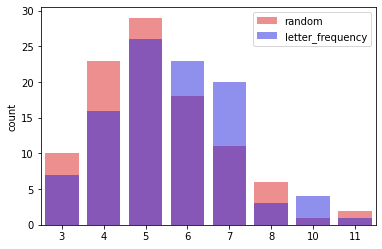

In [ ]:
sns.countplot(random, label='random', color='red', alpha=0.5)
sns.countplot(letter_frequency, label='letter_frequency', color='blue', alpha=0.5)
plt.legend()

## Example - Letter Likelihood V2


- Here, I take a live game, and snapshot guess points for future analysis.

### Guess 1

- strategy: eliminate all most likely letters.

In [ ]:
live = Guesser(word_df)

In [ ]:
live.snapshot_word_list()

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('s')]

In [ ]:
live.compute_probability_and_frequency()

In [ ]:
live.letter_frequency[live.letter_frequency.index.str.contains('[^s]')].idxmax()

'e'

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('e')]
live.compute_probability_and_frequency()

In [ ]:
live.letter_frequency.loc[live.letter_frequency.index.str.contains('[^se]')].idxmax()

'a'

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('a')]
live.compute_probability_and_frequency()

In [ ]:
live.letter_frequency.loc[live.letter_frequency.index.str.contains('[^sea]')].idxmax()

'r'

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('r')]
live.compute_probability_and_frequency()

In [ ]:
live.letter_frequency.loc[live.letter_frequency.index.str.contains('[^sear]')].idxmax()

'p'

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('p')]
live.compute_probability_and_frequency()

,word,1,2,3,4,5
1638,spare,s,p,a,r,e
1640,parse,p,a,r,s,e
2156,spear,s,p,e,a,r
2675,apers,a,p,e,r,s
2694,apres,a,p,r,e,s
2789,asper,a,s,p,e,r
8917,pares,p,a,r,e,s
8984,pears,p,e,a,r,s
9374,prase,p,r,a,s,e
9391,presa,p,r,e,s,a


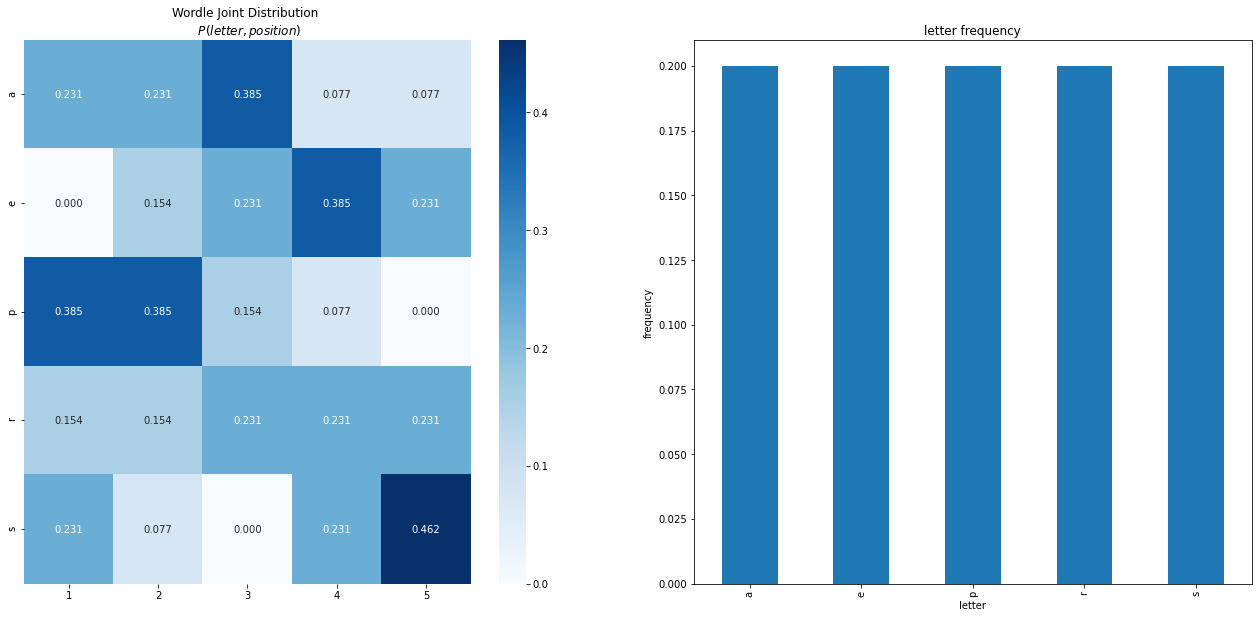

In [ ]:
live.plot_words()
live.word_df

### Guess 2

- Strategy: eliminate all most possible likely letters.

In [ ]:
live.restore_word_list_snapshot()
before_guess_1 = live.word_df.copy(deep=True)

In [ ]:
# Guessed Reaps
live.add_hint(letter='r', location=-1)
live.add_hint(letter='e')
live.add_hint(letter='a', location=-3)
live.add_hint(letter='p')
live.add_hint(letter='s', location=-5)
live.snapshot_word_list()
before_guess_2 = live.word_df.copy(deep=True)

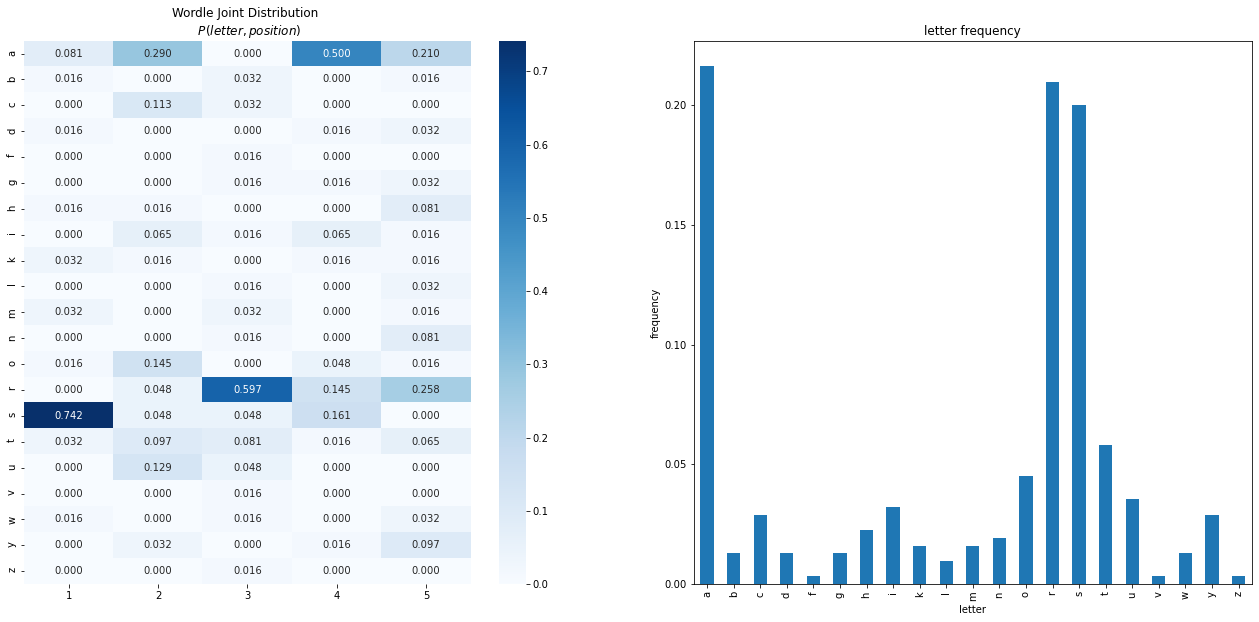

In [ ]:
live.plot_words()

Problem: we reduced the remaining list size too much, and guessed letters we already know about. We should have chosen from the original list.

In [ ]:
live.letter_frequency[live.letter_frequency.index.str.contains('[^reaps]')].idxmax()

't'

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('t')]
live.compute_probability_and_frequency()
live.letter_frequency[live.letter_frequency.index.str.contains('[^reapst]')].idxmax()

'i'

In [ ]:
live.word_df = live.word_df[live.word_df['word'].str.contains('i')]
live.compute_probability_and_frequency()

,word,1,2,3,4,5
2800,astir,a,s,t,i,r
10626,sitar,s,i,t,a,r
11159,stria,s,t,r,i,a
11425,tarsi,t,a,r,s,i


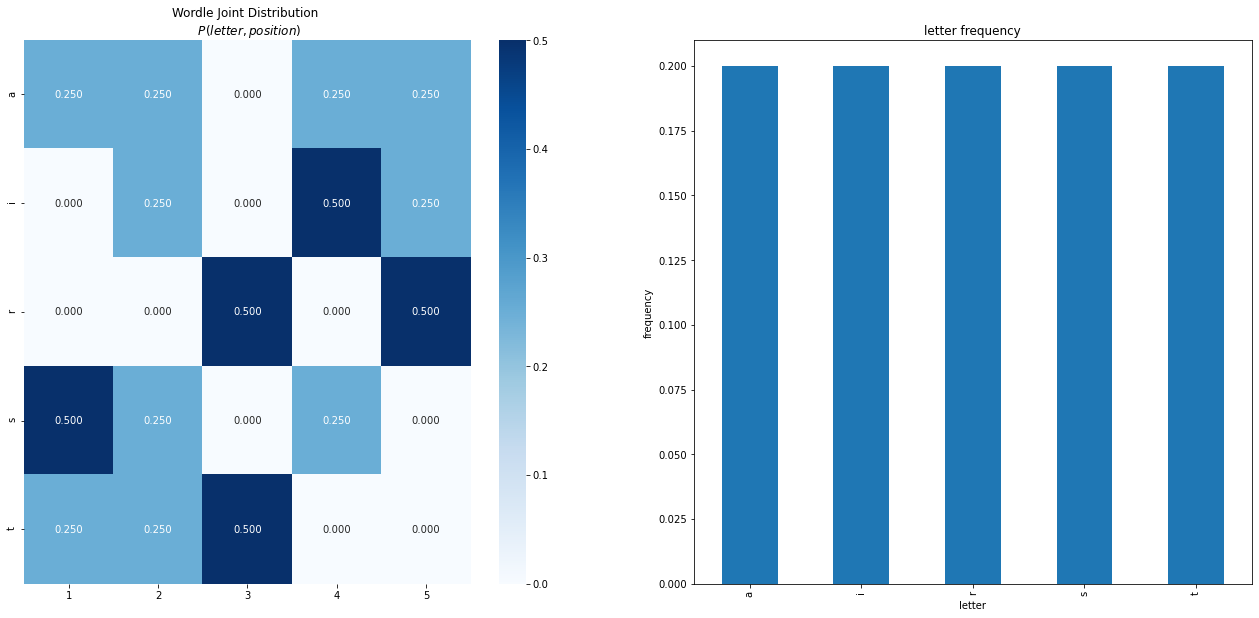

In [ ]:
live.plot_words()
live.word_df

### Guess 3

In [ ]:
live.restore_word_list_snapshot()

In [ ]:
# Guessed SITAR
live.add_hint(letter='s', location=1)
live.add_hint(letter='i')
live.add_hint(letter='t')
live.add_hint(letter='a', location=4)
live.add_hint(letter='r', location=5)
live.snapshot_word_list()
before_guess_3 = live.word_df.copy(deep=True)

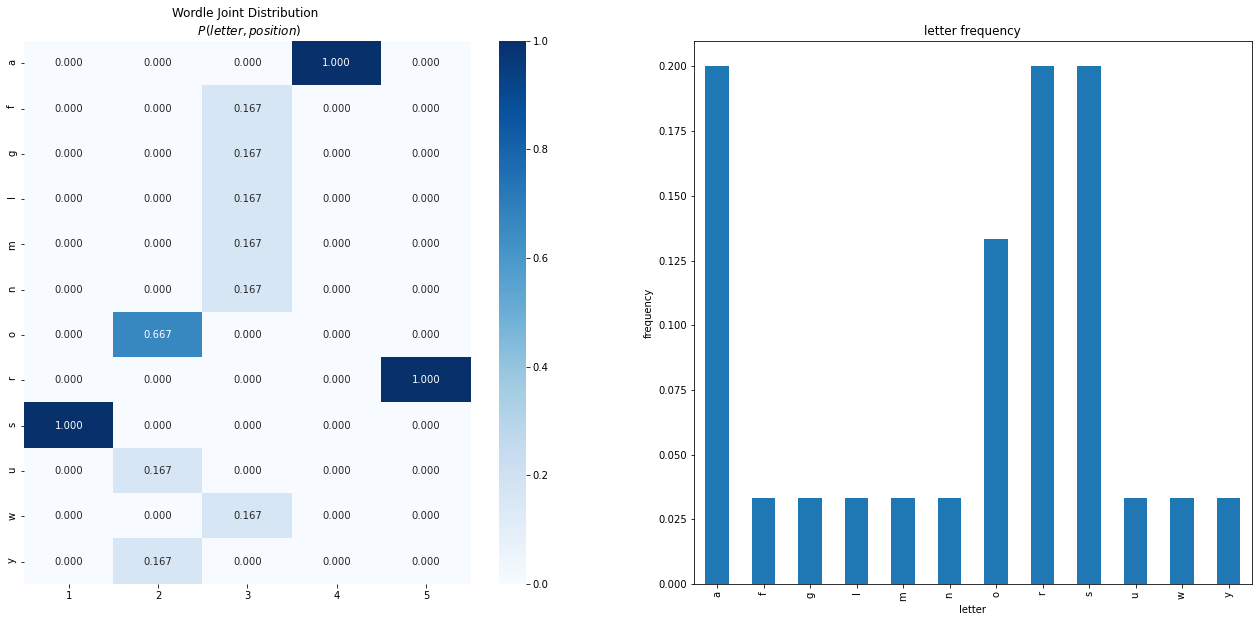

In [ ]:
live.plot_words()

In [ ]:
# Guess 4
# Guessed WOMYN
live.restore_word_list_snapshot()
live.add_hint('w')
live.add_hint('o')
live.add_hint('m')
live.add_hint('y')
live.add_hint('n')
live.snapshot_word_list()
before_guess_4 = live.word_df

In [ ]:
live.word_df

,word,1,2,3,4,5
220,sugar,s,u,g,a,r


## Another guessing strategy

In [ ]:
v2 = Guesser(word_df)
secret_word = "sugar"

In [ ]:
v2.word_df.shape

(12972, 6)

In [ ]:
# Guess 1
v2.guess('reaps', 'sugar')
v2.word_df.shape

	r is in secret word
	e is not in the word.
	a is in secret word
	p is not in the word.
	s is in secret word


(62, 6)

In [ ]:
# This guess eliminated:
12972 - 62

12910

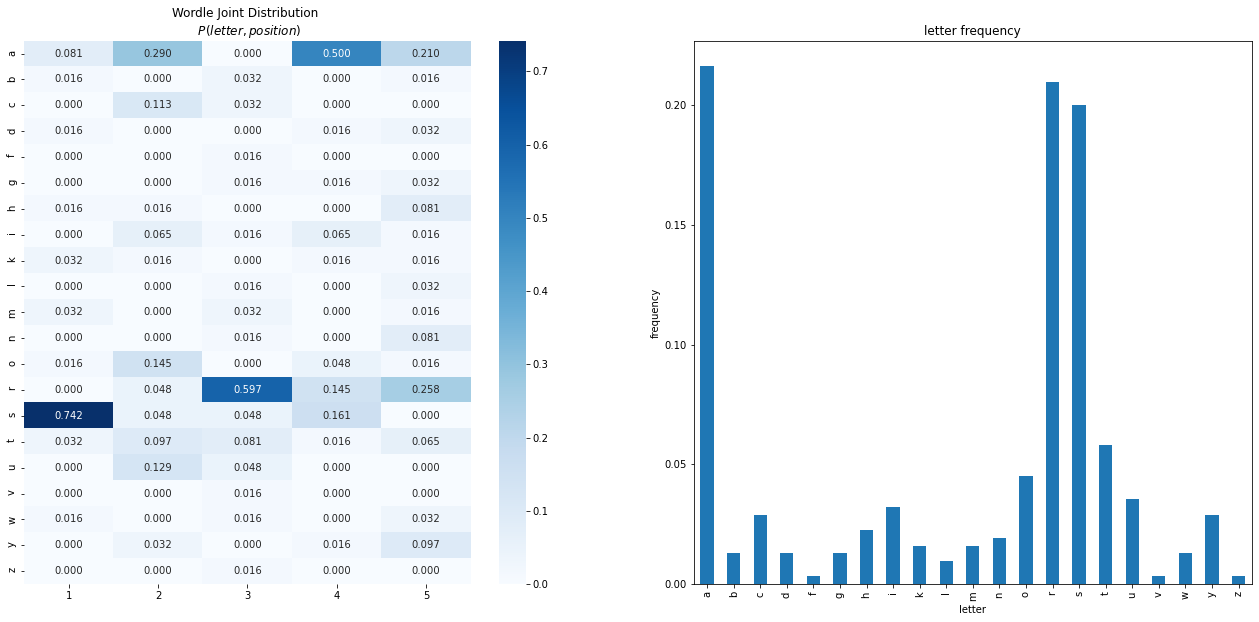

In [ ]:
v2.plot_words()

In [ ]:
# switch to elimination strategy
# 1. Filter original list
# 2. Prioritize guessing unknown letters
# 3. Prioritize guessing the maximum number of unknown letters
# 4. Prioritize guessing most likely unknown letters
# 5: built a simple regex here which forces it.
guesses = word_df[word_df['word'].str.contains('[^reaps][^reaps][^reaps][^reaps][^reaps]')]
guesses['unique'] = guesses['word'].apply(lambda x: len(set(list(x))))
guesses

/usr/local/google/home/mikebeaumier/colab_kernels/propensity.par:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,word,1,2,3,4,5,unique
25,colon,c,o,l,o,n,4
39,outdo,o,u,t,d,o,4
44,digit,d,i,g,i,t,4
46,cluck,c,l,u,c,k,4
48,mimic,m,i,m,i,c,3
...,...,...,...,...,...,...,...
12949,zooid,z,o,o,i,d,4
12953,zooty,z,o,o,t,y,4
12967,zuzim,z,u,z,i,m,4
12969,zygon,z,y,g,o,n,5


In [ ]:
def weight_guesses(word, letter_probability):
  score = 0.
  for letter in set(list(word)):
    try:
      score += letter_probability.loc[letter]
    except KeyError:
      # letter wasn't in probability, so it should not be guessed.
      pass
  return score

In [ ]:
guesses['weight'] = guesses['word'].apply(lambda x: weight_guesses(x, v2.letter_frequency))

/usr/local/google/home/mikebeaumier/colab_kernels/propensity.par:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
guesses.sort_values(by='weight', ascending=False)

,word,1,2,3,4,5,unique,weight
3914,chout,c,h,o,u,t,5,0.190323
426,youth,y,o,u,t,h,5,0.190323
8785,oucht,o,u,c,h,t,5,0.190323
1117,touch,t,o,u,c,h,5,0.190323
4192,couth,c,o,u,t,h,5,0.190323
...,...,...,...,...,...,...,...,...
392,fluff,f,l,u,f,f,3,0.048387
6634,immix,i,m,m,i,x,3,0.048387
5359,filii,f,i,l,i,i,3,0.045161
12258,villi,v,i,l,l,i,3,0.045161


In [ ]:
# Guess chout
v2.guess("chout", "sugar")

	c is not in the word.
	h is not in the word.
	o is not in the word.
	u is in secret word
	t is not in the word.


55

In [ ]:
# guess elimiated:
62 - 55

7

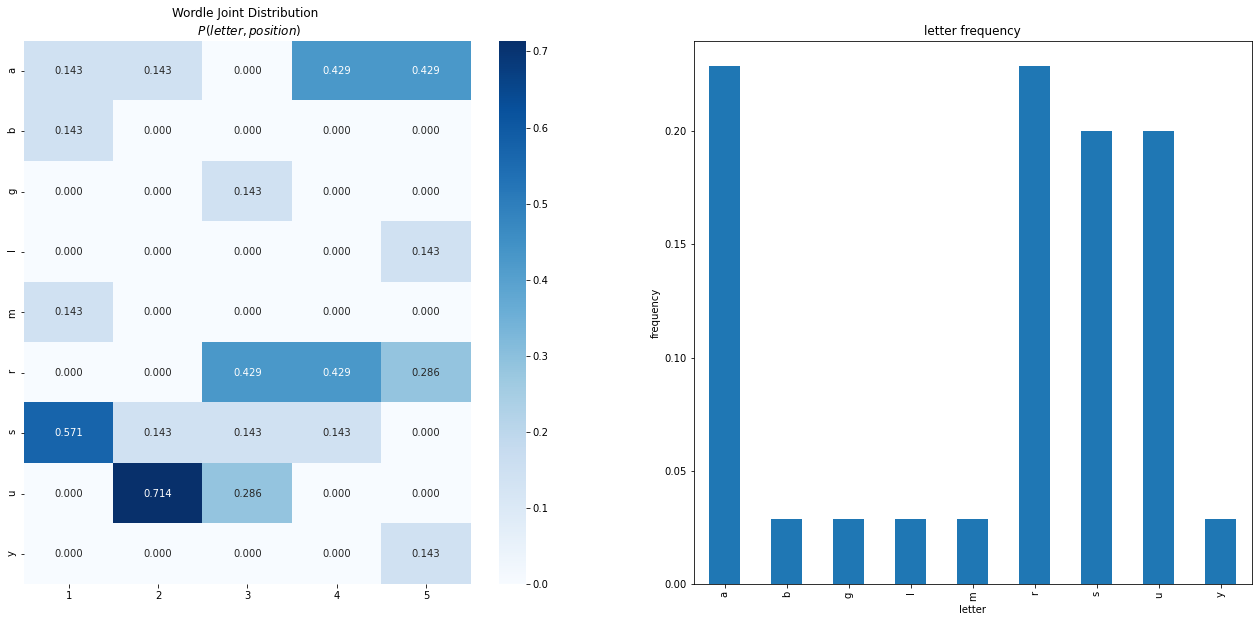

In [ ]:
v2.plot_words()

### Exploration vs Exploitation

- We can guess any word in the original word list, but each guess will only eliminate currently unknown words.

Therefore, there is probably an optimal point, where we guess from the full list, using the most likely letters from the restricted list.

In [ ]:
# Guess a word without `s`, `a`, `r`, but with `m`, `n`, `o`, `f`, `l`
guesses = word_df[word_df['word'].str.contains('[fglmnouwy][fglmnouwy][fglmnouwy][fglmnouwy][fglmnouwy]')]
guesses['unique'] = guesses['word'].apply(lambda x: len(set(list(x))))
guesses

/usr/local/google/home/mikebeaumier/colab_kernels/propensity.par:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,word,1,2,3,4,5,unique
289,lowly,l,o,w,l,y,4
360,gloom,g,l,o,o,m,4
392,fluff,f,l,u,f,f,3
460,gully,g,u,l,l,y,4
514,mummy,m,u,m,m,y,3
...,...,...,...,...,...,...,...
12619,wolly,w,o,l,l,y,4
12623,womyn,w,o,m,y,n,5
12632,woofy,w,o,o,f,y,4
12862,yummo,y,u,m,m,o,4


# Strategy - Example 1

Here, we manually execute a hybrid strategy, using the live wordle UI to validate responses.

The general strategy I used was:

1. Choose the most likely letter-position, so long as it was in the top 5 of the current known set.

2. Refilter the list with the guess in step `1.`, repeat step 1.

3. Continue until we have all guessed letters and positions.

This strategy reduced the word-list length in the first step by a factor of 10, but seemed to suffer as the list became shorter and shorter.

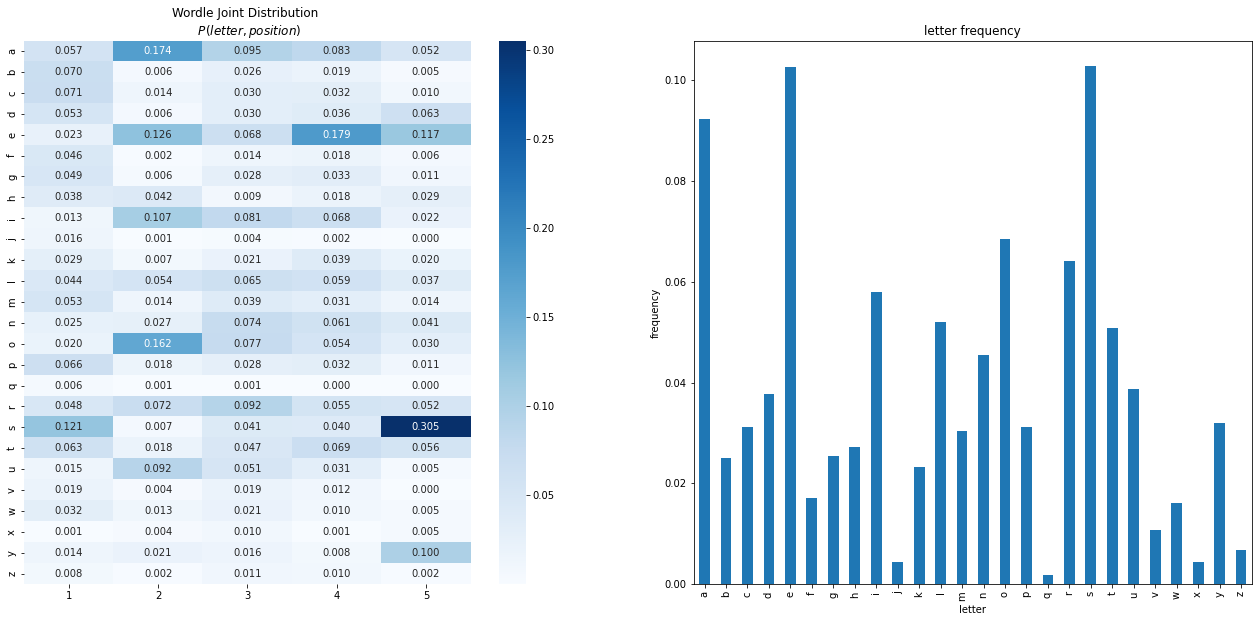

In [ ]:
words = make_word_df(wordlist)
game = Guesser(word_df=words)
game.plot_words()

In [ ]:
game.add_hint(letter='r')
game.add_hint(letter='e')
game.add_hint(letter='a')
game.add_hint(letter='s')
game.add_hint(letter='l', location=4)

In [ ]:
game.word_df

,word,1,2,3,4,5
99,moult,m,o,u,l,t
109,guild,g,u,i,l,d
150,chill,c,h,i,l,l
219,knoll,k,n,o,l,l
224,could,c,o,u,l,d
...,...,...,...,...,...,...
12330,voulu,v,o,u,l,u
12522,whilk,w,h,i,l,k
12619,wolly,w,o,l,l,y
12633,woold,w,o,o,l,d


In [ ]:
game.solved

{1: '?', 2: '?', 3: '?', 4: 'l', 5: '?'}

In [ ]:
game.snapshot_word_list()

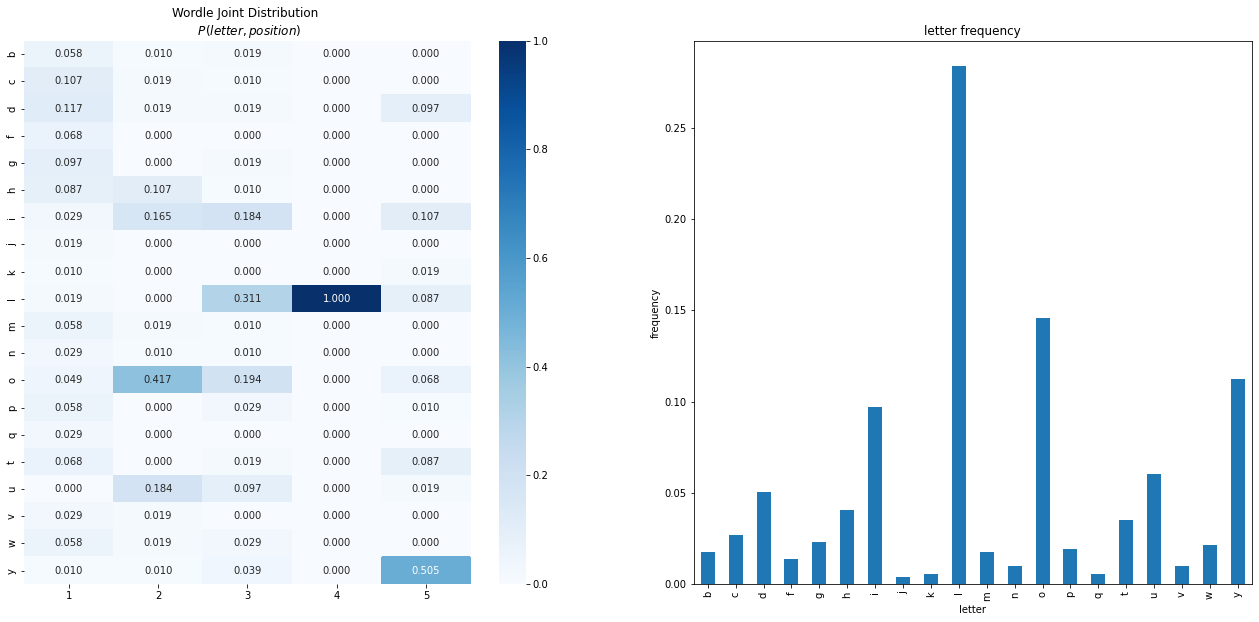

In [ ]:
game.plot_words()

In [ ]:
game.add_hint(letter='o', location=-2)
game.add_hint(letter='d')
game.add_hint(letter='i')
game.add_hint(letter='y')

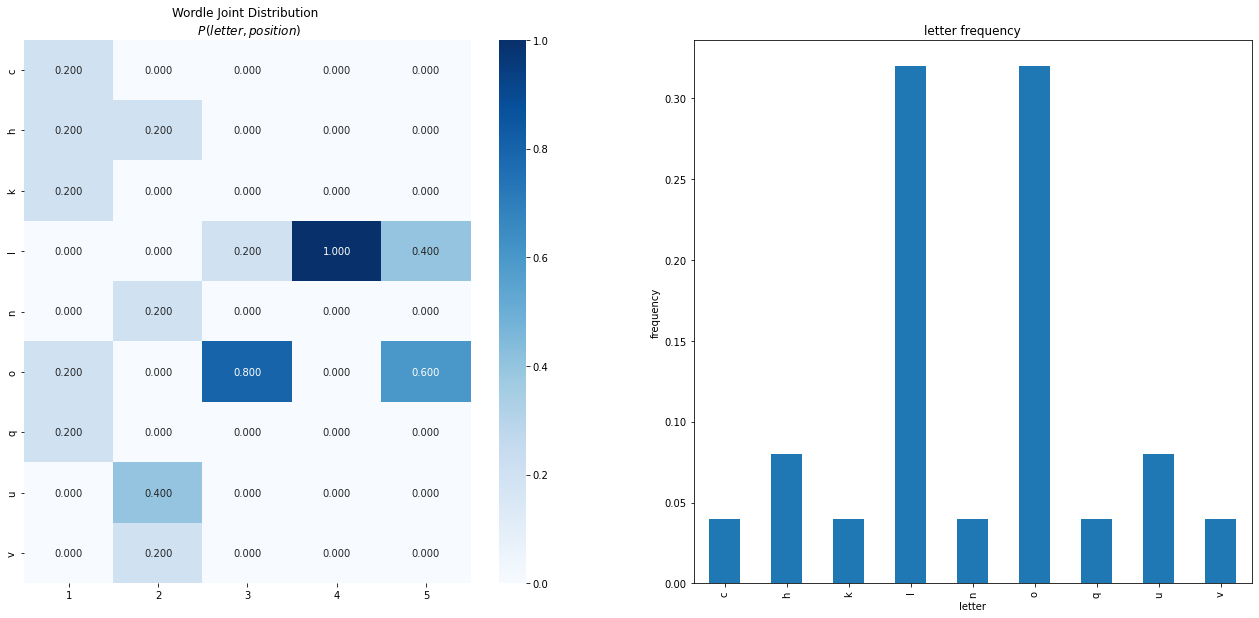

In [ ]:
game.plot_words()

In [ ]:
game.word_df

,word,1,2,3,4,5
219,knoll,k,n,o,l,l
3904,cholo,c,h,o,l,o
6538,hullo,h,u,l,l,o
8811,ovolo,o,v,o,l,o
9601,quoll,q,u,o,l,l


In [ ]:
game.snapshot_word_list()

In [ ]:
game.restore_word_list_snapshot()

In [ ]:
game.add_hint(letter='l', location=5)
game.add_hint(letter='q', location=-1)

	Secret word is solved: knoll


In [ ]:
game.word_df

,word,1,2,3,4,5
219,knoll,k,n,o,l,l


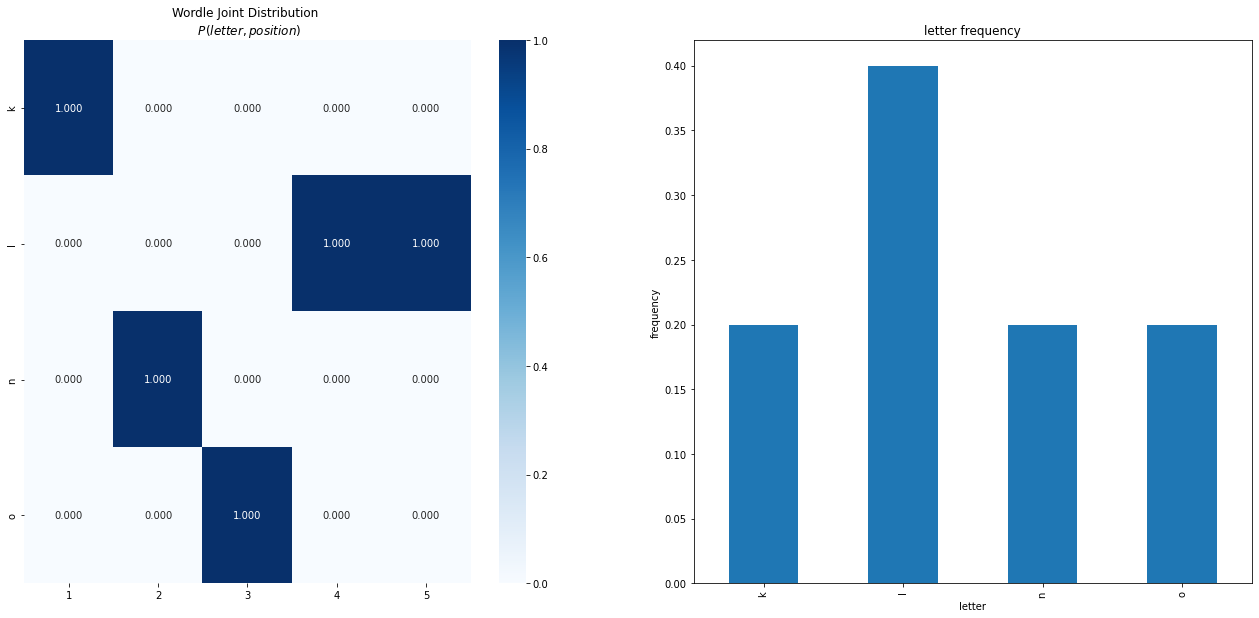

In [ ]:
game.plot_words()